In [ ]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../vision_fit'))  # insert parent path
import time
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import scipy
import pickle as pkl
import h5py
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import style
from imagenet_classes import lab_dict
import sklearn
import pandas as pd
import stats
import scipy.misc

%load_ext autoreload
%autoreload 2

In [272]:
style.set_style()
import warnings
warnings.filterwarnings("ignore")

# get data on labs, preds, and feats

In [273]:
out_dir = '/accounts/projects/vision/scratch/yu_dl/raaz.rsk/cnns_preds'
print(sorted(os.listdir(out_dir)))

# labs_train slightly smaller because part of last batch gets cut off
labs_train = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_train'])
labs_val = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_val'])

['.ipynb_checkpoints', 'alexnet.h5', 'alexnet_corrs.h5', 'alexnet_feats.h5', 'densenet121_corrs.h5', 'densenet169.h5', 'densenet169_corrs.h5', 'densenet169_feats.h5', 'densenet201_corrs.h5', 'ind_tops_train.pkl', 'ind_tops_train_corrs.pkl', 'ind_tops_val.pkl', 'ind_tops_val_corrs.pkl', 'labs.h5', 'readme.md', 'resnet101_corrs.h5', 'resnet152_corrs.h5', 'resnet18.h5', 'resnet18_corrs.h5', 'resnet18_feats.h5', 'resnet34_corrs.h5', 'resnet50.h5', 'resnet50_corrs.h5', 'vgg11.h5', 'vgg11_corrs.h5', 'vgg11_feats.h5', 'vgg13.h5', 'vgg13_corrs.h5', 'vgg13_feats.h5', 'vgg16.h5', 'vgg16_corrs.h5', 'vgg19.h5', 'vgg19_corrs.h5']


**hist correct points top pred vs hist wrong points top pred**

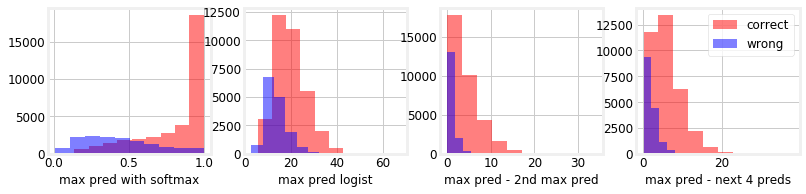

In [111]:
# params to set
preds = np.array(h5py.File(oj(out_dir, 'vgg11.h5'), 'r')['preds_val'])
labs = labs_val

# find right idxs
preds_max_class = np.argmax(preds, axis=1)
idxs_correct = preds_max_class == labs
preds = np.sort(preds, axis=1) # sort into ascending order for each row


R, C = 1, 4
plt.figure(figsize=(C * 3, R * 2.5))
preds_max = np.max(scipy.special.softmax(preds, axis=1), axis=1) #[:, -1]
plt.subplot(R, C, 1)
plt.hist(preds_max[idxs_correct], color='red', alpha=0.5)
plt.hist(preds_max[~idxs_correct], color='blue', alpha=0.5)
plt.xlabel('max pred with softmax')

plt.subplot(R, C, 2)
preds_max = preds[:, -1]
plt.xlabel('max pred logit')
plt.hist(preds_max[idxs_correct], color='red', alpha=0.5, label='correct')
plt.hist(preds_max[~idxs_correct], color='blue', alpha=0.5, label='wrong')

plt.subplot(R, C, 3)
preds_max = preds[:, -1] - preds[:, -2]
plt.xlabel('max pred - 2nd max pred')
plt.hist(preds_max[idxs_correct], color='red', alpha=0.5, label='correct')
plt.hist(preds_max[~idxs_correct], color='blue', alpha=0.5, label='wrong')

plt.subplot(R, C, 4)
preds_max = preds[:, -1] - (preds[:, -2] + preds[:, -3] + preds[:, -4] + preds[:, -5]) / 4
plt.xlabel('max pred - next 4 preds')
plt.hist(preds_max[idxs_correct], color='red', alpha=0.5, label='correct')
plt.hist(preds_max[~idxs_correct], color='blue', alpha=0.5, label='wrong')
plt.legend()
plt.show()

# look at features

In [12]:
# n x feat_size
feats_train = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_train']
feats_val = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_val']

(50000, 4096)

In [13]:
sims = metrics.pairwise.cosine_similarity(feats_val[:10000])
print(sims.shape)

(10000, 10000)


In [ ]:
plt.figure(figsize=(14, 14))
plt.imshow(sims, interpolation=None)
plt.grid(False)
plt.savefig('act_sims.pdf')
plt.show()

In [10]:
means = np.mean(feats_val, axis=0)
stds = np.std(feats_val, axis=0)

In [ ]:
sns.heatmap(feats_val[:10, :4096])
plt.show()

In [14]:
print(feats_val.shape)

(50000, 4096)


# look at individual ims

In [6]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import torch

root = '/scratch/users/vision/data/cv/imagenet_full'

In [7]:
dset_name = 'val/val' # train or val/val
dset_val = dset.ImageFolder(oj(root, dset_name), 
                            transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor()]))

# find closest nn point

In [275]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [351]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
def get_im(dset, idx):
    im = dset_val[idx][0]
    im_np = deepcopy(im.numpy()).transpose((1, 2, 0))
    im_torch = normalize(im).unsqueeze_(0)
    return im_np, im_torch

# convert im_torch back to unnormalized numpy im
# 1 x 3 x 224 x 224 -> 224 x 224 x 3
def im_to_np(im_torch):
    means = np.array([0.485/0.229, 0.456/0.224, 0.406/0.255]).T
    stds = np.array([0.229, 0.224, 0.255]).T
    im_np = deepcopy(im_torch.cpu().detach().numpy()[0]).transpose((1, 2, 0))
    im_np +=  means
    im_np *=  stds
    return im_np

# show an image
# if given list of images, show them all
def show(im, dpi=100):
    plt.figure(dpi=dpi)
    if type(im) == list:
        #plt.figure(figsize=(3 * len(im), 3), dpi=dpi)
        for i in range(len(im)):
            plt.subplot(1, len(im), i + 1)
            plt.imshow(im[i])
            plt.grid(False)
            plt.axis('off')        
            plt.tight_layout()
    else:
        plt.imshow(im)
        plt.grid(False)
        plt.axis('off')        

In [277]:
m = models.alexnet(pretrained=True).eval()
class_num = 84
offset = 50 * class_num
im_num = offset + 3

im_np, im_torch = get_im(dset_val, im_num)
# show(im_np)
# pred = m(im_torch) # this matches what's in preds

search within class for neighbors

In [278]:
preds = np.array(h5py.File(oj(out_dir, 'alexnet.h5'), 'r')['preds_val'])
feats = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_val']

feats_all = np.array(feats[offset: offset + 50])
feats_im = np.array(feats[im_num])

preds_all = np.array(preds[offset: offset + 50])
preds_im = np.array(preds[im_num])

In [279]:
# dists = feats_all @ feats_im.T # dot prods
dists = np.linalg.norm(feats_all - feats_im, axis=1, ord=2) # l2 dists
# dists = np.linalg.norm(preds_all - preds_im, axis=1, ord=2) # l2 dist in prediction
inds_sorted = np.argsort(dists) # increasing

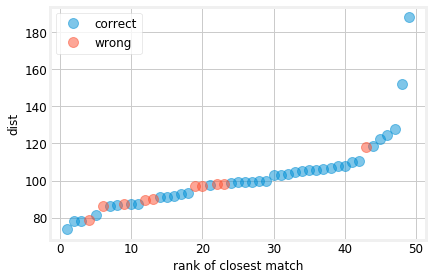

In [280]:
ranks = np.arange(dists.size)
inds_correct = np.argmax(preds_all[inds_sorted], axis=1) == class_num
plt.plot(ranks[inds_correct][1:], dists[inds_sorted][inds_correct][1:], 'o', label='correct')
plt.plot(ranks[~inds_correct], dists[inds_sorted][~inds_correct], 'o', label='wrong')
plt.legend()
plt.xlabel('rank of closest match')
plt.ylabel('dist')
plt.show()

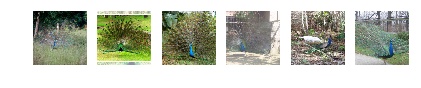

In [281]:
for j in range(6):
    plt.subplot(1, 6, j + 1)
    im_np, im_torch = get_im(dset_val, offset + inds_sorted[j])
    show(im_np)
plt.show()

# sgd vs adam

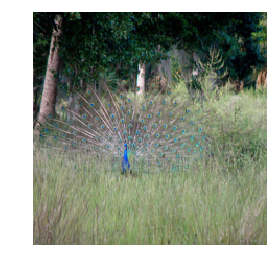

In [282]:
im1_np, im1_torch = get_im(dset_val, offset + inds_sorted[0])
show(im1_np)

In [364]:
device = 'cuda'
m = m.to(device)
# im = torch.zeros(im1_torch.shape, requires_grad=True, device=device)
im = torch.randn(im1_torch.shape, requires_grad=True, device=device)

# im = im1_torch.clone().to(device)
# im.requires_grad = True
pred = m(im1_torch.to(device)).data
opt = torch.optim.Adam({im}, lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# opt = torch.optim.SGD({im}, lr=0.01) #, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [ ]:
num_iters = int(1e5)
results_dir = 'ims_adam_1e-2_from_noise'
save_freq = 1000
os.makedirs(results_dir, exist_ok=True)
for i in range(num_iters):
    m.zero_grad()
    # output is 1 x 1000
    loss = -1 * m(im)[0, 0] # .norm() # max act
#     loss = (pred - m(im)).norm() # max act    
    loss.backward()
    opt.step()    
    if i % (save_freq / 10) == 0:
        print(f'{loss.detach().item():.2f}', end=' ')
    if i % save_freq == 0:
        print('saved')
        im_reshaped = im_to_np(im)   
        scipy.misc.imsave(f'{results_dir}/im_epoch={i}_loss={loss.detach().item():.2f}.jpg', im_reshaped)

In [ ]:
im_reshaped = im_to_np(im)
show(im_reshaped)

In [ ]:
plt.hist(im_reshaped.flatten())

# compare 2 ims

In [204]:
im1_np, im1_torch = get_im(dset_val, offset + inds_sorted[0])
im2_np, im2_torch = get_im(dset_val, offset + inds_sorted[1])
feats1 = feats[offset + inds_sorted[0]]
feats2 = feats[offset + inds_sorted[1]]

In [160]:
m = models.alexnet(pretrained=True).eval().to('cuda')

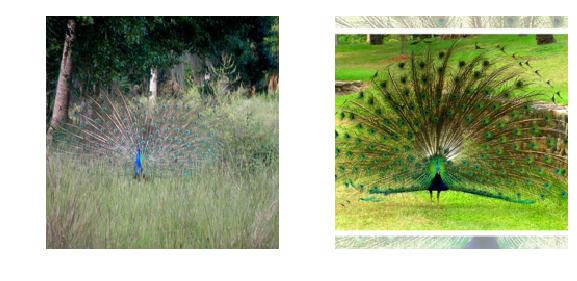

In [314]:
show([im1_np, im2_np])

In [377]:
class ActOpt:
    def __init__(self, device='cuda'):
        # extract features from one of the last layers
        self.feat_size = 4096
        self.feats = torch.zeros(1, feat_size, requires_grad=True, device=device)
    
    def register_forward(self, model, model_name, feat_size):
        if model_name == 'alexnet' or 'vgg' in model_name:
#             layer = model.classifier[-1]
#             layer = model.features[0]
            layer = model.features[-1]
        elif 'resnet' in model_name:
            layer = model.fc
        elif 'densenet' in model_name:
            layer = model.classifier

        # features will be the input of the selected layer
        def copy_data(m, i, o):
            # print('copying...')
            self.feats = i[0] # i is a tuple
        layer.register_forward_hook(copy_data)

act_opt = ActOpt()
m = models.alexnet(pretrained=True).eval().to('cuda')
act_opt.register_forward(m, 'alexnet', 4096)

In [378]:
# take an image and optimize so activations match
# im1, im2 should be torch tensors
def optimize_im(im1, im2, m, act_opt=None, num_iters=int(1e3), lr=1e-2, device='cuda', save_freq=250):
#     im = im2_torch.clone().to(device)
#     im.requires_grad = True
    im = torch.zeros(im1.shape, requires_grad=True, device=device)
#     target = m(im1.to(device)).data 
    m(im1.to(device)) # forward pass
    target = act_opt.feats.data
    
    opt = torch.optim.SGD({im}, lr=lr) #, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    losses = np.zeros(num_iters)
    ims_opt = []
    for i in range(num_iters):
        m.zero_grad()
#         loss = (target - m(im)).norm(p=1.5) # max act, output is 1 x 1000 
        m(im) # forward pass
        loss = (target - act_opt.feats).norm(p=1.5) # match feats, output is 1 x 1000                
        losses[i] = loss.detach().item()
        loss.backward(retain_graph=True)
        opt.step()   
        if i % save_freq == 0:
            ims_opt.append(deepcopy(im.detach().cpu()))
    return ims_opt, losses


ims_opt, losses = optimize_im(im1_torch, im2_torch, m, act_opt)

In [ ]:
im_opt = ims_opt[-1]
show([im2_np, im_to_np(im_opt), 
      im_to_np(im_opt - im2_torch), im_to_np(im_opt - im1_torch)], dpi=100)
show([im_to_np(im) for im in ims_opt], dpi=100)

In [ ]:
plt.semilogy(losses)
plt.ylabel('dist')
plt.xlabel('iter')